


# PyTorch Basics

I'll assume that everyone is familiar with Python. Training neural nets in bare Python is somewhat painful, but fortunately there are several well-established libraries which can help. I like PyTorch, which is built upon an earlier library called Torch. (There are many others, including TensorFlow and Jax, both of which I would encourage you to explore at your leisure.)


In [1]:
import numpy as np
import torch
import torchvision

Torch believes that everything is a *tensor*.

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.50439784 0.65183142 0.68007372]
 [0.62489785 0.29530714 0.25021235]]
tensor([[0.5044, 0.6518, 0.6801],
        [0.6249, 0.2953, 0.2502]], dtype=torch.float64)


The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon we will see that training neural nets basically involves *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about Torch variables is that they (natively) can be differentiated. (Again, we will see why this is important when we learn about backpropagation in deep learning.) 

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1,requires_grad=True)

y = torch.matmul(A,x) + b

print(y)

tensor([[1.7848],
        [0.6922]], grad_fn=<AddBackward0>)


In [4]:
z = y.sum()
print(z)

tensor(2.4770, grad_fn=<SumBackward0>)


Here, *z* is a function of the input *x*. Let us now compute the derivative of *z* with respect to *x* using backpropagation.

In [5]:
z.backward()
print(x.grad)
print(x)

tensor([[1.1662],
        [1.1186]])
tensor([[0.9062],
        [0.8383]], requires_grad=True)


# Training simple models

OK, enough background. Let us now train a simple model. We will train a logistic classifier (equivalent to a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. (TorchVision has several other image datasets which we can directly load as variables, feel free to train your own models on them). 

In [6]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

Let's quickly check that everything has been downloaded.

In [7]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Some of you might know that this is the same size as the (very commonly used) MNIST dataset. Let's plot some images.

In [8]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the 'image' object since it is a Torch tensor, so let's convert it back into a numpy array before displaying it. We will use matplotlib to show images.

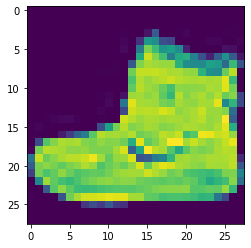

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

OK, that kinda sorta looks like a shoe? FashionMNIST is basically a bunch of black-white thumbnail images of different pieces of clothing. Let's try and plot a few of them. To step through the dataset, it will be helpful to construct a *data loader* object; we will use this while training our model below as well.

In [10]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's now use the DataLoader object to spit out a few images from the dataset.

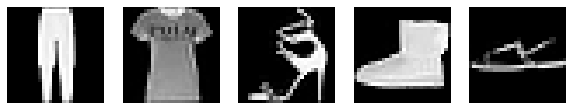

In [11]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(5):
    plt.subplot(1, 5, index + 1)
    # Assuming the images are in the format [C, H, W] and are grayscale
    # Adjust the image for visualization (transpose axes from [C, H, W] to [H, W, C])
    # For grayscale images, we also need to remove the channel dimension using squeeze()
    image = images[index].squeeze().numpy() # Assuming the images are tensors
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Optionally remove axes
plt.show()


OK! Time to set up our model. 

In [12]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

#net = LinearReg().cuda()
net = LinearReg()

Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Cool! Everything is set up. Let's now train our network.

In [13]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images #.cuda()
    labels = labels #.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images#.cuda()
      labels = labels#.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.9621340601937349, Test loss 0.7394919412530911
Epoch 1, Train loss 0.6691029809558315, Test loss 0.6461336050823236
Epoch 2, Train loss 0.6042623796633312, Test loss 0.6052873483888662
Epoch 3, Train loss 0.5693143640499888, Test loss 0.578290012611705
Epoch 4, Train loss 0.5460724961211179, Test loss 0.5607606476279581
Epoch 5, Train loss 0.5295098571539688, Test loss 0.5480926086188881
Epoch 6, Train loss 0.5168062865352834, Test loss 0.5387338777636267
Epoch 7, Train loss 0.5066047295578507, Test loss 0.5285879646896556
Epoch 8, Train loss 0.4981436572794213, Test loss 0.5201477759582981
Epoch 9, Train loss 0.4909728092870224, Test loss 0.5155826461542944
Epoch 10, Train loss 0.4848154078382673, Test loss 0.5092619577790521
Epoch 11, Train loss 0.47948520401838235, Test loss 0.5047450190896441
Epoch 12, Train loss 0.4745373961164245, Test loss 0.5023296593101161
Epoch 13, Train loss 0.4706059626297656, Test loss 0.4982469786124624
Epoch 14, Train loss 0.4667091

Let's see how we did! We have tracked the losses so let's plot it.

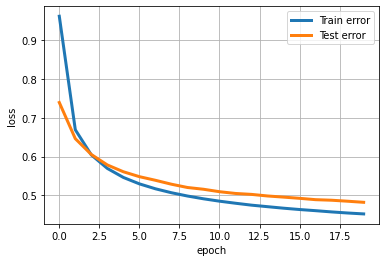

In [14]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Not too bad (although more epochs would have helped, I suppose). Let's evaluate our final model on a few more images to wrap things up.

In [15]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)
print(fit)

torch.return_types.max(
values=tensor([ 6.2237,  3.0372,  9.0339,  7.7760,  6.5787,  6.2366, 10.2492,  4.2017,
         6.9332, 11.5690, 10.4518, 10.3631,  6.7414,  4.6767,  9.3038,  4.5035],
       grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5]))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
tensor(0.3320, grad_fn=<NllLossBackward0>)


Cool, looks like 2 images in this batch are being misclassified; can you (as a human) guess what those are?

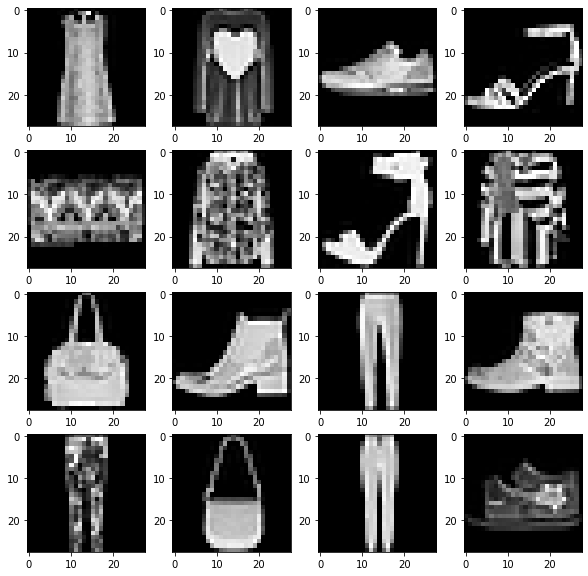

In [16]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)